In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [23]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['balance-09-ratio-1', 'balance-10-ratio-1', 'balance-11-ratio-1', 'balance-12-ratio-1']
# schedule_names = ['balance-10-ratio-1']

In [24]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/fcfs_schedule.csv', '../output/KTH-io-aware/filler_schedule.csv', '../output/KTH-io-aware/no-reserve-1_schedule.csv']
['../output/KTH-io-aware/backfill-1_jobs.csv', '../output/KTH-io-aware/balance-09-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-10-largest-1_jobs.csv', '../output/KTH-io-aware/balance-10-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-11-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-12-ratio-1_jobs.csv', '../output/KTH-io-aware/fcfs_jobs.csv', '../output/KTH-io-aware/filler_jobs.csv', '../output/KTH-io-aware/no-reserve-1_jobs.csv']


In [25]:
def schedule_params(schedule_name):
    _, balance_factor, priority_policy, _ = schedule_name.split('-')
    balance_factor = float(balance_factor) / 10
    return priority_policy, balance_factor

In [26]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df['priority_policy'] = priority_policy
        df['balance_factor'] = balance_factor
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 balance-09-ratio-1
 balance-10-ratio-1
 balance-11-ratio-1
 balance-12-ratio-1


In [27]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)
        jobsets[schedule_name].df['priority_policy'] = priority_policy
        jobsets[schedule_name].df['balance_factor'] = balance_factor

 balance-09-ratio-1
 balance-10-ratio-1
 balance-11-ratio-1
 balance-12-ratio-1


In [28]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [29]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [79]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

def create_balance_metric_df():
    dfs = []
    for schedule in schedule_names:
        priority_policy, balance_factor = schedule_params(schedule)
        dfs.append(jobsets[schedule].df[['waiting_time', 'turnaround_time', 'stretch']].assign(priority_policy=priority_policy).assign(balance_factor=balance_factor))
    return pd.concat(dfs)

In [31]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [32]:
metrics.T

schedule,balance-09-ratio-1,balance-10-ratio-1,balance-11-ratio-1,balance-12-ratio-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.87898e+07,2.8805e+07,2.8788e+07,2.88035e+07
max_slowdown,1.00022,1.00023,1.00024,1.00024
max_turnaround_time,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975921,0.975917,0.97592,0.97592
mean_turnaround_time,223.719,223.755,223.69,223.728
mean_waiting_time,0,0,0,0
nb_computing_machines,109,109,109,109


<AxesSubplot:xlabel='balance_factor'>

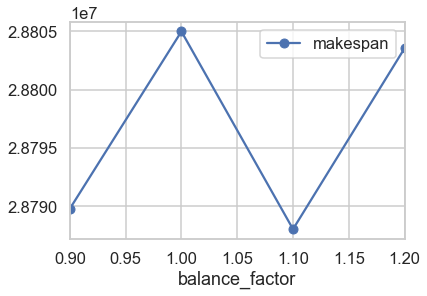

In [58]:
metrics.plot(x='balance_factor', y='makespan', marker='o')

<AxesSubplot:xlabel='balance_factor'>

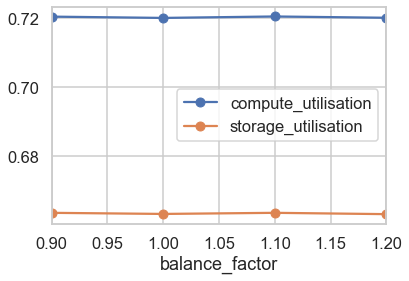

In [56]:
metrics.plot(x='balance_factor', y=['compute_utilisation', 'storage_utilisation'], marker='o')

<AxesSubplot:xlabel='balance_factor'>

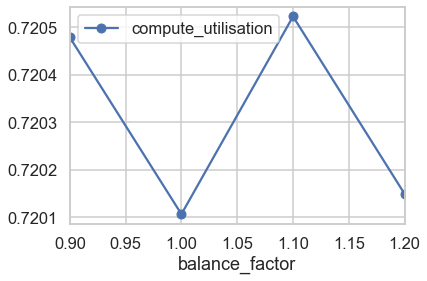

In [59]:
metrics.plot(x='balance_factor', y='compute_utilisation', marker='o')

<AxesSubplot:xlabel='balance_factor'>

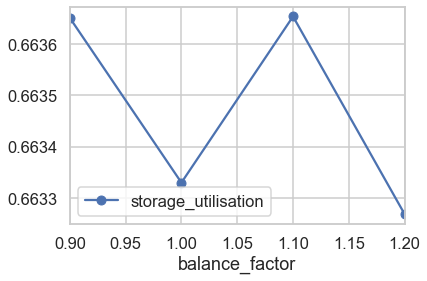

In [60]:
metrics.plot(x='balance_factor', y='storage_utilisation', marker='o')

<AxesSubplot:xlabel='balance_factor', ylabel='compute_utilisation'>

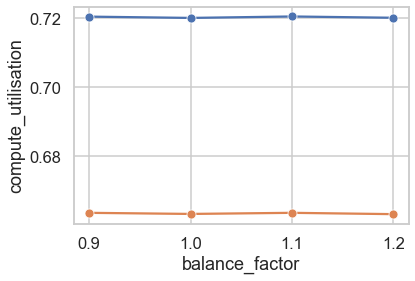

In [57]:
sns.lineplot(data=metrics[['balance_factor', 'compute_utilisation']], x='balance_factor', y='compute_utilisation', marker='o')
sns.lineplot(data=metrics[['balance_factor', 'storage_utilisation']], x='balance_factor', y='storage_utilisation', marker='o')

In [40]:
metrics[['balance_factor', 'compute_utilisation', 'storage_utilisation']]

,balance_factor,compute_utilisation,storage_utilisation
schedule,,,
balance-09-ratio-1,0.9,0.720479,0.663651
balance-10-ratio-1,1.0,0.720106,0.663330
balance-11-ratio-1,1.1,0.720523,0.663654
balance-12-ratio-1,1.2,0.720149,0.663269


In [82]:
df = create_balance_metric_df()

In [93]:
df[['balance_factor', 'waiting_time', 'stretch']].groupby('balance_factor').describe()

waiting_time                                        \
                      count          mean           std  min  25%   
balance_factor                                                      
0.9                 28453.0  14506.555321  44645.886430  0.0  0.0   
1.0                 28453.0  14365.201637  43620.005995  0.0  0.0   
1.1                 28453.0  14048.378544  42551.538859  0.0  0.0   
1.2                 28453.0  13833.674809  42557.378235  0.0  0.0   

                                                          stretch              \
                         50%          75%            max    count        mean   
balance_factor                                                                  
0.9             0.000000e+00  7418.850943  749023.992565  28453.0  144.735163   
1.0             9.983778e-07  7671.222279  624105.772425  28453.0  153.419959   
1.1             0.000000e+00  7028.859747  677743.769461  28453.0  143.110411   
1.2             0.000000e+00  6678.107605  589357.183284  28453.0  146.848442   

                                                                     
                        std  min  25%  50%       75%            max  
balance_factor                                                       
0.9              835.363436  1.0  1.0  1.0  5.241030   47086.735948  
1.0             1107.950147  1.0  1.0  1.0  5.945451  103806.438014  
1.1             1046.789724  1.0  1.0  1.0  5.597540  104436.182006  
1.2             1067.831730  1.0  1.0  1.0  4.686927  104436.175020

<AxesSubplot:xlabel='balance_factor', ylabel='waiting_time'>

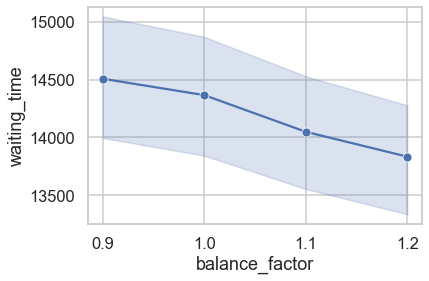

In [84]:
sns.lineplot(data=df, x='balance_factor', y='waiting_time', estimator=np.mean, marker='o')

<AxesSubplot:xlabel='balance_factor', ylabel='stretch'>

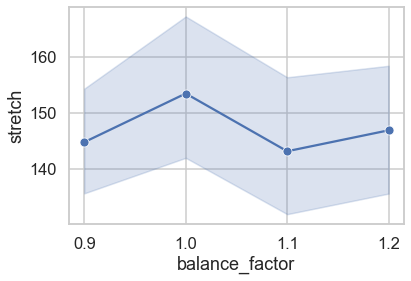

In [94]:
sns.lineplot(data=df, x='balance_factor', y='stretch', estimator=np.mean, marker='o')